In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Load the dataset
df = pd.read_csv('merged_ml_dataset.csv')

# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nSummary statistics:")
print(df.describe())# Remove the whole row in datset which carry the null value


Dataset shape: (15245, 35)

First few rows:
  pdb_id Affinity Data  pKd pKi pIC50 ligand_id  Molecular Weight  \
0   6ugp    Ki=685.5nM           6.16       Q7A           232.644   
1   6ugq     Ki=28.2nM           7.55       Q7A           232.644   
2   6ugr    Ki=533.6nM           6.27       Q71           216.190   
3   6ugz     Ki=19.1nM           7.72       Q71           216.190   
4   6uh0    Ki=853.1nM           6.07       PX7           212.226   

   ligand_atoms_x  Polar Surface Area  XLOGP3  h_bond_donors  \
0            19.0               83.65    0.76            2.0   
1            19.0               83.65    0.76            2.0   
2            19.0               83.65    0.23            2.0   
3            19.0               83.65    0.23            2.0   
4            22.0               74.86    0.32            1.0   

   h_bond_acceptors  ...  ligand_P pi_stacking  metal_coordination  \
0               3.0  ...         0           0                   0   
1               

In [2]:
# Remove the whole row in datset which carry the null value
df = df.dropna(subset=['affinity_value', 'affinity_units','Molecular Weight' ,'ligand_atoms_x' ,'Polar Surface Area' , 'XLOGP3','h_bond_donors','h_bond_acceptors','Rotatable bonds','affinity_type'])

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check the shape of data after removing the row
print(f"Dataset shape: {df.shape}")

# Convert categorical variables to numerical
df['affinity_type'] = df['affinity_type'].astype('category').cat.codes

# Check for duplicates
print(f"\nNumber of duplicates: {df.duplicated().sum()}")


Missing values:
pdb_id                         0
Affinity Data                  0
pKd pKi pIC50                  0
ligand_id                      0
Molecular Weight               0
ligand_atoms_x                 0
Polar Surface Area             0
XLOGP3                         0
h_bond_donors                  0
h_bond_acceptors               0
Rotatable bonds                0
affinity_type                  0
affinity_value                 0
affinity_units                 0
pKd_standardized               0
ligand_atoms_y                 0
hbonds                         0
hydrophobic                    0
salt_bridges                   0
pocket_atoms                   0
pocket_volume                  0
ligand_C                       0
ligand_N                       0
ligand_O                       0
ligand_S                       0
ligand_P                       0
pi_stacking                    0
metal_coordination             0
polar_contacts                 0
buried_surface_area       

In [3]:
# Removing Duplicate
df = df.drop_duplicates()
print(f"\nNumber of duplicates: {df.duplicated().sum()}")


# Check the shape of data after removing the row
print(f"Dataset shape: {df.shape}")

print(df.head())


Number of duplicates: 0
Dataset shape: (12526, 35)
  pdb_id Affinity Data  pKd pKi pIC50 ligand_id  Molecular Weight  \
0   6ugp    Ki=685.5nM           6.16       Q7A           232.644   
1   6ugq     Ki=28.2nM           7.55       Q7A           232.644   
2   6ugr    Ki=533.6nM           6.27       Q71           216.190   
3   6ugz     Ki=19.1nM           7.72       Q71           216.190   
4   6uh0    Ki=853.1nM           6.07       PX7           212.226   

   ligand_atoms_x  Polar Surface Area  XLOGP3  h_bond_donors  \
0            19.0               83.65    0.76            2.0   
1            19.0               83.65    0.76            2.0   
2            19.0               83.65    0.23            2.0   
3            19.0               83.65    0.23            2.0   
4            22.0               74.86    0.32            1.0   

   h_bond_acceptors  ...  ligand_P  pi_stacking  metal_coordination  \
0               3.0  ...         0            0                   0   
1     

In [5]:
# Split data into train, validation, and test sets (70/15/15)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

Training set size: 8768
Validation set size: 1879
Test set size: 1879


In [4]:

# Create new features that might be relevant
#The ratio: It helps you understand the proportion of carbon atoms compared to other atoms (N, O, S, P) in the ligand, which might have biological relevance, such as molecule interactions or solubility properties.
#To prevent this error, you add a small number (1e-6) to the denominator. This ensures that if the sum of N, O, S, and P is zero, it won’t break the program

df['ligand_atom_ratio'] = df['ligand_C'] / (df['ligand_N'] + df['ligand_O'] + df['ligand_S'] + df['ligand_P'] + 1e-6)
df['h_bond_total'] = df['h_bond_donors'] + df['h_bond_acceptors']
df['polar_nonpolar_ratio'] = df['Polar Surface Area'] / (df['Molecular Weight'] + 1e-6)

# Log transform the target variable if needed (pKd is already logarithmic)
# We'll use pKd_standardized as our target

# Separate features and target
X = df.drop(columns=['pdb_id', 'ligand_id', 'pKd_standardized', 'affinity_value'])
y = df['pKd_standardized']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")



Numerical features: 31
Categorical features: 2


MODEL TRAINING


In [12]:
print(df['pKd_standardized'].head(20))


0      6.160000
1      7.550000
2      6.270000
3      7.720000
4      6.070000
5      6.397940
6      6.920819
7      6.431798
8      7.096910
9      6.744727
10    10.522879
11     7.890000
12     8.640000
13     8.177832
14     9.004365
15    10.552842
16    11.000000
17    10.810000
18    11.680000
19     4.430000
Name: pKd_standardized, dtype: float64


In [6]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR()
}

# Train and evaluate initial models
results = {}  
for name, model in models.items():
    model.fit(X_train[numerical_cols], y_train)  # Using only numerical cols for simplicityc
    y_pred = model.predict(X_val[numerical_cols])
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

# Display initial results
results_df = pd.DataFrame(results).T
print("\nInitial Model Performance:")
print(results_df.sort_values('R2', ascending=False))


Linear Regression: RMSE = 1.2137, R2 = 0.6262
Ridge Regression: RMSE = 1.2136, R2 = 0.6262
Lasso Regression: RMSE = 1.5986, R2 = 0.3515
Random Forest: RMSE = 1.1565, R2 = 0.6606
Gradient Boosting: RMSE = 1.1709, R2 = 0.6521
Support Vector Regression: RMSE = 1.3653, R2 = 0.5270

Initial Model Performance:
                               RMSE        R2
Random Forest              1.156545  0.660557
Gradient Boosting          1.170894  0.652082
Ridge Regression           1.213640  0.626216
Linear Regression          1.213653  0.626208
Support Vector Regression  1.365298  0.526961
Lasso Regression           1.598591  0.351491


In [7]:
# Hyperparameter tuning for the best performing models
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Random Forest tuning
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train[numerical_cols], y_train)
best_rf = grid_search_rf.best_estimator_

# Gradient Boosting tuning
gb = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gb.fit(X_train[numerical_cols], y_train)
best_gb = grid_search_gb.best_estimator_

# Evaluate tuned models
tuned_models = {
    'Tuned Random Forest': best_rf,
    'Tuned Gradient Boosting': best_gb
}

tuned_results = {}
for name, model in tuned_models.items():
    model.fit(X_train[numerical_cols], y_train)
    y_pred = model.predict(X_val[numerical_cols])
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    tuned_results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

# Display tuned results
tuned_results_df = pd.DataFrame(tuned_results).T
print("\nTuned Model Performance:")
print(tuned_results_df.sort_values('R2', ascending=False))

Tuned Random Forest: RMSE = 1.1563, R2 = 0.6607
Tuned Gradient Boosting: RMSE = 1.1551, R2 = 0.6614

Tuned Model Performance:
                             RMSE        R2
Tuned Gradient Boosting  1.155113  0.661397
Tuned Random Forest      1.156254  0.660728


In [8]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Simplified + Randomized parameter distributions (instead of grid search)
param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

param_dist_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4]
}

# Fast Randomized SearchCV for Random Forest
rf = RandomForestRegressor(random_state=42)
random_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist_rf,
    n_iter=5, cv=3, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=42
)
random_search_rf.fit(X_train[numerical_cols], y_train)
best_rf = random_search_rf.best_estimator_

# Fast Randomized SearchCV for Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
random_search_gb = RandomizedSearchCV(
    gb, param_distributions=param_dist_gb,
    n_iter=5, cv=3, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=42
)
random_search_gb.fit(X_train[numerical_cols], y_train)
best_gb = random_search_gb.best_estimator_

# Evaluate the tuned models on validation data
tuned_models = {
    'Tuned Random Forest': best_rf,
    'Tuned Gradient Boosting': best_gb
}

tuned_results = {}
for name, model in tuned_models.items():
    model.fit(X_train[numerical_cols], y_train)
    y_pred = model.predict(X_val[numerical_cols])
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    tuned_results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

# Convert to DataFrame for easy viewing
tuned_results_df = pd.DataFrame(tuned_results).T
print("\n Tuned Model Performance:")
print(tuned_results_df.sort_values('R2', ascending=False))


C:\Users\madhv\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuned Random Forest: RMSE = 1.1554, R2 = 0.6612
Tuned Gradient Boosting: RMSE = 1.1551, R2 = 0.6614

 Tuned Model Performance:
                             RMSE        R2
Tuned Gradient Boosting  1.155113  0.661397
Tuned Random Forest      1.155371  0.661246


In [9]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


# Build the MLP model
model_mlp = Sequential()
model_mlp.add(Dense(128, activation='relu', input_shape=(X_train[numerical_cols].shape[1],)))
model_mlp.add(Dropout(0.2))  # Add dropout for regularization
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dropout(0.2))
model_mlp.add(Dense(1))  # Output layer for regression

# Compile the model
model_mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_mlp = model_mlp.fit(X_train[numerical_cols], y_train,
                            validation_data=(X_val[numerical_cols], y_val),
                            epochs=100, batch_size=32,
                            callbacks=[early_stopping], verbose=1)

# Evaluate on the test set
y_pred_mlp = model_mlp.predict(X_test[numerical_cols])
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"MLP - RMSE: {rmse_mlp:.4f}, R2: {r2_mlp:.4f}")

# ... (rest of your code for saving models, plotting, etc.)

C:\Users\madhv\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 16.9518 - mae: 3.1421 - val_loss: 2.2298 - val_mae: 1.0924
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0394 - mae: 1.3507 - val_loss: 1.7888 - val_mae: 0.9829
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6512 - mae: 1.2608 - val_loss: 1.6390 - val_mae: 0.9815
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4218 - mae: 1.2184 - val_loss: 1.6374 - val_mae: 1.0875
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2781 - mae: 1.1932 - val_loss: 1.5116 - val_mae: 0.9598
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2928 - mae: 1.1926 - val_loss: 1.4832 - val_mae: 0.9228
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1581 - mae: 1.1572 - val_loss: 1.4407 - val_mae: 0.9211
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1321 - mae: 1.1477 - val_loss: 1.5178 - val_mae: 0.8557
Epoch 9/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms

In [10]:
!pip install tensorflow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np



# Reshape data for CNN (add a channel dimension)
X_train_cnn = X_train[numerical_cols].values.reshape(X_train[numerical_cols].shape[0], X_train[numerical_cols].shape[1], 1)
X_val_cnn = X_val[numerical_cols].values.reshape(X_val[numerical_cols].shape[0], X_val[numerical_cols].shape[1], 1)
X_test_cnn = X_test[numerical_cols].values.reshape(X_test[numerical_cols].shape[0], X_test[numerical_cols].shape[1], 1)

# Build the CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1))  # Output layer for regression

# Compile the model
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_cnn = model_cnn.fit(X_train_cnn, y_train,
                            validation_data=(X_val_cnn, y_val),
                            epochs=100, batch_size=32,
                            callbacks=[early_stopping], verbose=1)

# Evaluate on the test set
y_pred_cnn = model_cnn.predict(X_test_cnn)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
r2_cnn = r2_score(y_test, y_pred_cnn)

print(f"CNN - RMSE: {rmse_cnn:.4f}, R2: {r2_cnn:.4f}")


  Using cached numpy-2.1.3-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.1.3-cp310-cp310-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
Epoch 1/100


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prody 2.4.1 requires numpy<1.24,>=1.10, but you have numpy 2.1.3 which is incompatible.
C:\Users\madhv\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 18.8576 - mae: 3.2576 - val_loss: 2.9114 - val_mae: 1.3661
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1293 - mae: 1.4097 - val_loss: 1.9802 - val_mae: 1.1728
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4415 - mae: 1.2514 - val_loss: 1.6845 - val_mae: 1.0723
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2818 - mae: 1.1990 - val_loss: 1.6520 - val_mae: 0.9468
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1344 - mae: 1.1597 - val_loss: 1.9015 - val_mae: 0.9363
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1927 - mae: 1.1775 - val_loss: 1.5168 - val_mae: 0.9570
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1073 - mae: 1.1463 - val_loss: 1.5494 - val_mae: 0.8858
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1356 - mae: 1.1531 - val_loss: 1.4621 - val_mae: 0.9880
Epoch 9/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss

In [13]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR(),
    'MLP': None,  # Placeholder for MLP results
    'CNN': None   # Placeholder for CNN results
}

# Train and evaluate initial models
results = {}
for name, model in models.items():
    if model is not None:  # Skip MLP and CNN which were trained separately
        model.fit(X_train[numerical_cols], y_train)
        y_pred = model.predict(X_val[numerical_cols])
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        results[name] = {'RMSE': rmse, 'R2': r2}
        print(f"{name}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

# Add the neural network results that were obtained separately
results['MLP'] = {'RMSE': 1.1636, 'R2': 0.6394}
results['CNN'] = {'RMSE': 1.1675, 'R2': 0.6369}

# Display initial results
results_df = pd.DataFrame(results).T
print("\nInitial Model Performance:")
print(results_df.sort_values('R2', ascending=False))

Linear Regression: RMSE = 1.2137, R2 = 0.6262
Ridge Regression: RMSE = 1.2136, R2 = 0.6262
Lasso Regression: RMSE = 1.5986, R2 = 0.3515
Random Forest: RMSE = 1.1565, R2 = 0.6606
Gradient Boosting: RMSE = 1.1709, R2 = 0.6521
Support Vector Regression: RMSE = 1.3653, R2 = 0.5270

Initial Model Performance:
                               RMSE        R2
Random Forest              1.156545  0.660557
Gradient Boosting          1.170894  0.652082
MLP                        1.163600  0.639400
CNN                        1.167500  0.636900
Ridge Regression           1.213640  0.626216
Linear Regression          1.213653  0.626208
Support Vector Regression  1.365298  0.526961
Lasso Regression           1.598591  0.351491


C:\Users\madhv\AppData\Local\Temp\ipykernel_1436\748077795.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models, rotation=45, ha='right')
C:\Users\madhv\AppData\Local\Temp\ipykernel_1436\748077795.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models, rotation=45, ha='right')


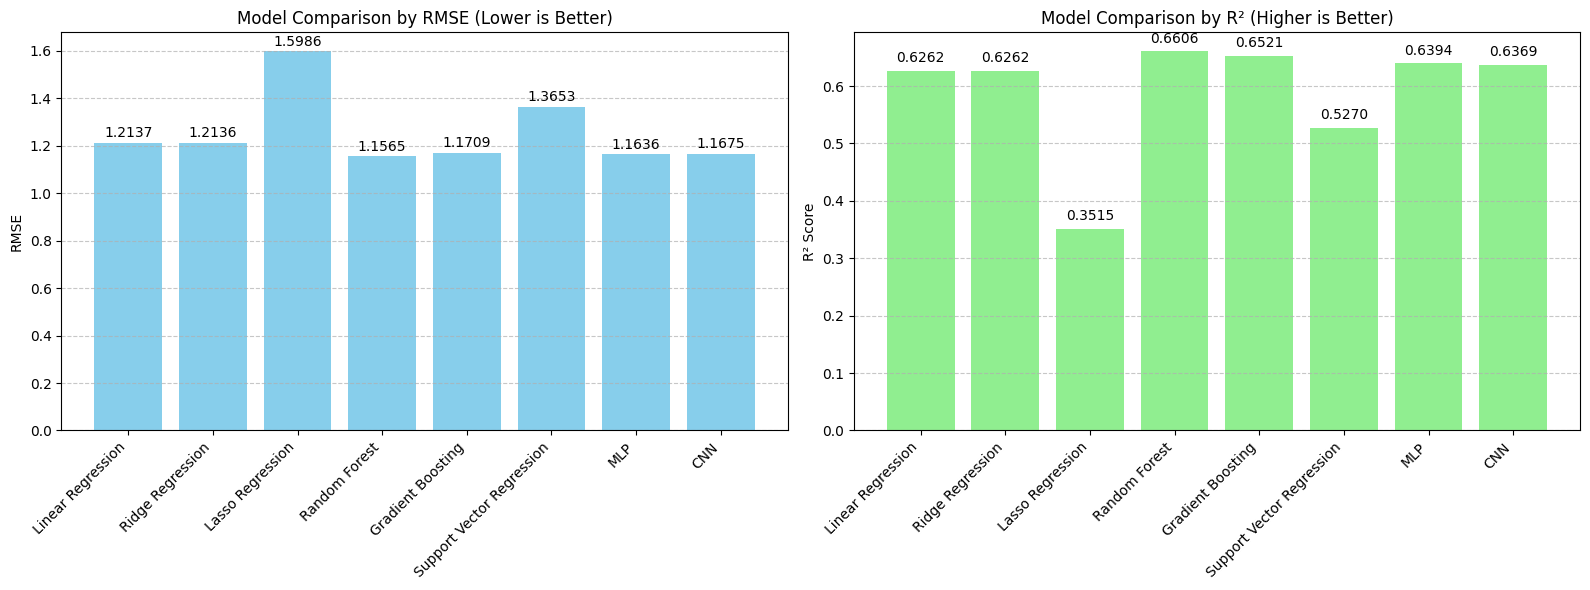

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
models = results_df.index
rmse_values = results_df['RMSE']
r2_values = results_df['R2']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# RMSE plot (lower is better)
ax1.bar(models, rmse_values, color='skyblue')
ax1.set_title('Model Comparison by RMSE (Lower is Better)')
ax1.set_ylabel('RMSE')
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# R² plot (higher is better)
ax2.bar(models, r2_values, color='lightgreen')
ax2.set_title('Model Comparison by R² (Higher is Better)')
ax2.set_ylabel('R² Score')
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for i, v in enumerate(rmse_values):
    ax1.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')
    
for i, v in enumerate(r2_values):
    ax2.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

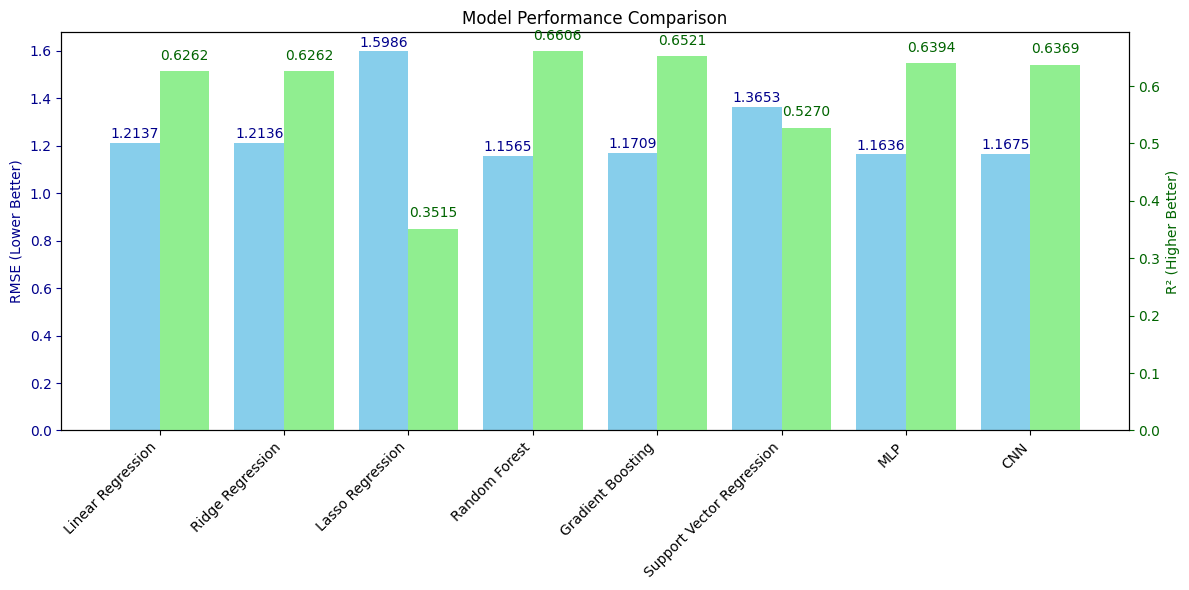

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# RMSE bars
ax1.bar(np.arange(len(models))-0.2, rmse_values, 
        width=0.4, color='skyblue', label='RMSE')
ax1.set_ylabel('RMSE (Lower Better)', color='darkblue')
ax1.tick_params(axis='y', colors='darkblue')
ax1.set_xticks(np.arange(len(models)))
ax1.set_xticklabels(models, rotation=45, ha='right')

# R² line plot
ax2 = ax1.twinx()
ax2.bar(np.arange(len(models))+0.2, r2_values, 
        width=0.4, color='lightgreen', label='R²')
ax2.set_ylabel('R² (Higher Better)', color='darkgreen')
ax2.tick_params(axis='y', colors='darkgreen')

# Add values
for i, v in enumerate(rmse_values):
    ax1.text(i-0.2, v+0.02, f"{v:.4f}", ha='center', color='darkblue')
    
for i, v in enumerate(r2_values):
    ax2.text(i+0.2, v+0.02, f"{v:.4f}", ha='center', color='darkgreen')

plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()

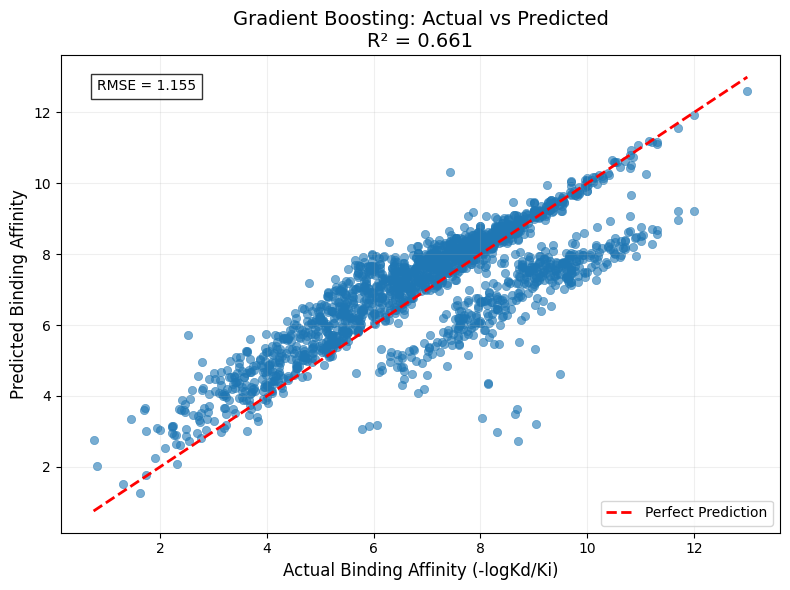

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Get predictions from  best model (assuming 'best_gb' is your tuned Gradient Boosting model)
best_model = tuned_models['Tuned Gradient Boosting']  # Replace with your actual model variable
y_pred = best_model.predict(X_val[numerical_cols])

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.6, edgecolor=None)

# Add reference line (perfect predictions)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'r--', lw=2, label='Perfect Prediction')

# Add labels and title
plt.xlabel('Actual Binding Affinity (-logKd/Ki)', fontsize=12)
plt.ylabel('Predicted Binding Affinity', fontsize=12)
plt.title(f'Gradient Boosting: Actual vs Predicted\nR² = {r2_score(y_val, y_pred):.3f}', fontsize=14)

# Add grid and legend
plt.grid(alpha=0.2)
plt.legend()

# Annotate RMSE
plt.text(0.05, 0.95, f"RMSE = {np.sqrt(mean_squared_error(y_val, y_pred)):.3f}",
         transform=plt.gca().transAxes, ha='left', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

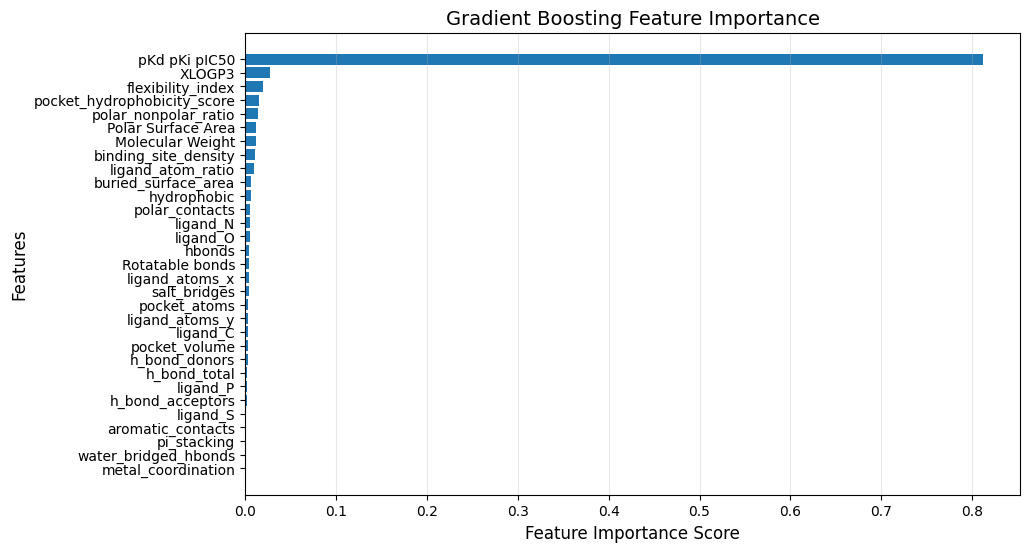

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from your tuned Gradient Boosting model
feature_importance = best_gb.feature_importances_
features = X_train[numerical_cols].columns

# Create DataFrame and sort features
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#1f77b4')
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Gradient Boosting Feature Importance', fontsize=14)
plt.gca().invert_yaxis()  # Most important at top
plt.grid(axis='x', alpha=0.3)
plt.show()

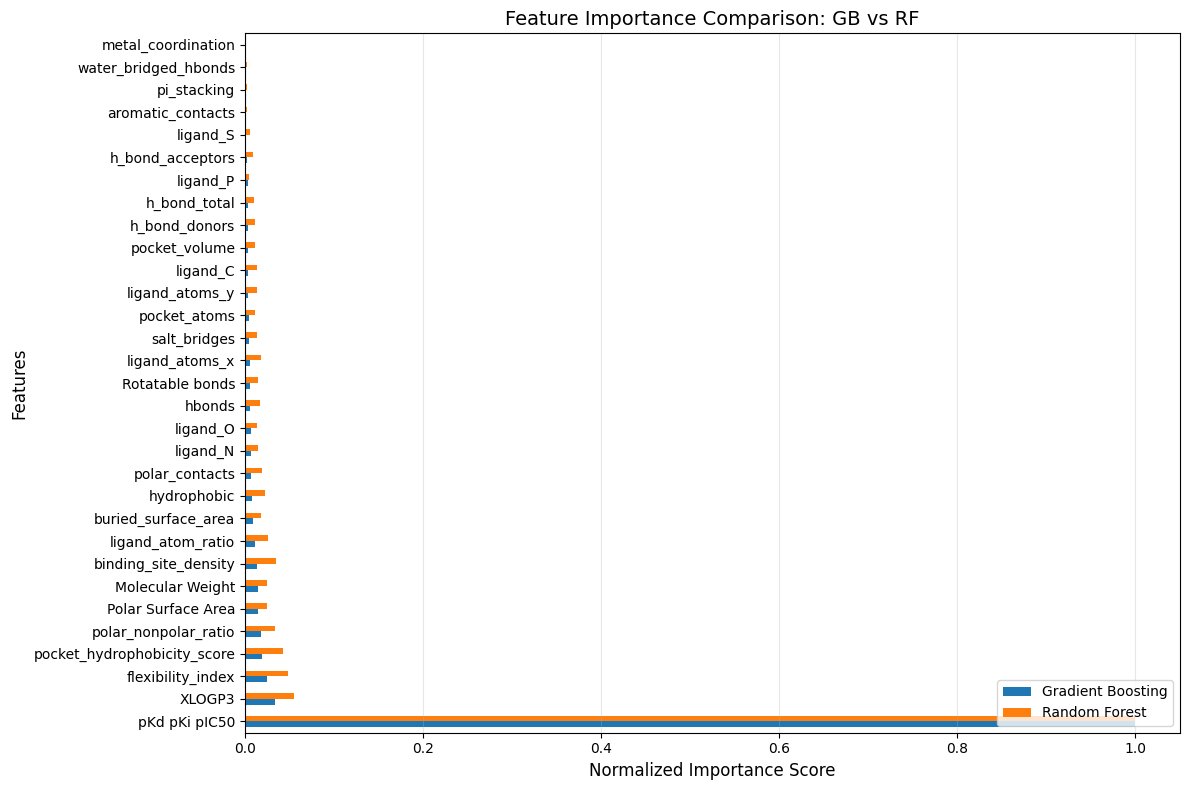

In [22]:
# Get Random Forest feature importance
rf_importance = best_rf.feature_importances_

# Create comparison DataFrame
compare_df = pd.DataFrame({
    'Feature': features,
    'Gradient Boosting': feature_importance,
    'Random Forest': rf_importance
}).set_index('Feature')

# Normalize and sort
compare_df = compare_df.apply(lambda x: x / x.max())  # Relative importance (0-1)
compare_df = compare_df.sort_values('Gradient Boosting', ascending=False)

# Plot side-by-side
compare_df.plot(kind='barh', figsize=(12, 8), color=['#1f77b4', '#ff7f0e'])
plt.title('Feature Importance Comparison: GB vs RF', fontsize=14)
plt.xlabel('Normalized Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.legend(loc='lower right')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()